# Inspiration
- https://medium.com/@xjurajkmec/pairwise-learning-for-neural-link-prediction-f1d16a0d28f6#:~:text=The%20idea%20of%20using%20graph,edges%20in%20the%20given%20graph
-

In [25]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from torch import torch

In [26]:
postings_1 = pd.read_csv("../data/Postings_01052019_15052019.csv", sep = ';')
postings_2 = pd.read_csv("../data/Postings_16052019_31052019.csv", sep = ';')
votes_1 = pd.read_csv("../data/Votes_01052019_15052019.csv", sep = ';')
votes_2 = pd.read_csv("../data/Votes_16052019_31052019.csv", sep = ';')

postings = pd.concat([postings_1, postings_2])
votes = pd.concat([votes_1, votes_2])

In [27]:
from sklearn import preprocessing

post_article = postings.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).agg({"ArticlePublishingDate": "min"})
post_article = post_article.reset_index()
votes_trunc = votes[['ID_CommunityIdentity', 'ID_Posting']]
postings_trunc = postings.groupby(by = ['ID_Posting', 'ID_Article']).agg({"ArticlePublishingDate": "min"}).reset_index().drop(columns = ['ArticlePublishingDate'])
vote_user_article = votes_trunc.merge(postings_trunc, left_on = ['ID_Posting'], right_on = ['ID_Posting'])
vote_article = vote_user_article.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).agg({"ID_Posting": "count"}).reset_index().drop(columns = ['ID_Posting'])
# user_article_interaction = pd.concat([post_article, vote_article]).drop(columns=['ArticlePublishingDate'])
user_article_interaction = pd.concat([post_article]).drop(columns=['ArticlePublishingDate'])

In [28]:
# subset edges
user_article_interaction = user_article_interaction.sample(n=int(user_article_interaction.shape[0]/20), random_state=1)

In [29]:
user_article_interaction.shape

(17391, 2)

In [179]:
user_article_interaction["user_id"] = "u-" + user_article_interaction["ID_CommunityIdentity"].astype(str)
user_article_interaction["article_id"] = "a-" + user_article_interaction["ID_Article"].astype(str)

nodes = np.concatenate((np.unique(user_article_interaction['user_id']), np.unique(user_article_interaction['article_id'])))
nodes_user = np.unique(user_article_interaction['user_id'])
nodes_article = np.unique(user_article_interaction['article_id'])

label_encoder_nodes = preprocessing.LabelEncoder()
label_encoder_nodes.fit(nodes)
nodes_enc = label_encoder_nodes.transform(nodes)

user_article_interaction["user_id_enc"] = label_encoder_nodes.transform(user_article_interaction["user_id"])
user_article_interaction["article_enc"] = label_encoder_nodes.transform(user_article_interaction["article_id"])

In [180]:
edge_list = []
for row in user_article_interaction.itertuples():
    edge_list.append([row.user_id_enc, row.article_enc])

from torch_geometric.data import Data

x = torch.tensor(nodes_enc, dtype=torch.long)
edge_index = torch.tensor(edge_list, dtype=torch.long)
graph = Data(x=x, edge_index=edge_index.t().contiguous())

graph.validate(raise_on_error=True)

True

In [181]:

# from torch_geometric.data import Data

# class BipartiteData(Data):
#     pass

# graph_bi = BipartiteData(x_u=label_encoder_nodes.transform(nodes_user), 
#                     x_a=label_encoder_nodes.transform(nodes_article),
#                     edge_index=edge_index)

In [182]:
# from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit
# import copy

# ## designed for transductive learning
# tfs = RandomLinkSplit(
#                     #   is_undirected=True, 
#                       add_negative_train_samples=True,
#                       neg_sampling_ratio=1.0,
#                       key = "edge_label", # supervision label
#                       # disjoint_train_ratio=0,# disjoint mode if > 0
#                       # edge_types=None, # for heteroData
#                       # rev_edge_types=None, # for heteroData
#                       num_val=0.1,
#                       num_test=0.1,
#                       disjoint_train_ratio=0.7
#                       )
# train_data, val_data, test_data = tfs(graph)
# # Here, *_data.edge_index denotes the graph structure used for message passing,
# # *_data.edge_label_index and *_data.edge_label denote the training/evaluation edges and their corresponding labels. 

# ## if inductive learning, need subgraph. e.g 
# from torch_geometric.utils import subgraph
# train_mask = torch.rand(graph.num_nodes) < 0.5
# test_mask = ~train_mask

# train_data = copy.copy(graph)
# train_data.edge_index, _ = subgraph(train_mask, graph.edge_index, relabel_nodes=True)
# train_data.x = graph.x[train_mask]


# test_data = copy.copy(graph)
# test_data.edge_index, _ = subgraph(test_mask, graph.edge_index, relabel_nodes=True)
# test_data.x = graph.x[test_mask]

In [83]:
train_data

Data(x=[5405], edge_index=[2, 4614])

In [57]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
print("Cuda is available: ", torch.cuda.is_available())

Cuda is available:  True


In [58]:
graph.edge_index.to(device)

tensor([[ 9511, 10496,  8169,  ...,  4777,  2818,  7096],
        [ 2280,  2411,  2531,  ...,  1560,   257,   496]], device='cuda:0')

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.data import DataLoader
from torch_geometric.utils import negative_sampling
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator #needed to extract and evaluate the ogb-ddi dataset
import matplotlib.pyplot as plt #needed to visualize loss curves
import numpy as np 

In [60]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, emb=False):
        super(GNNStack, self).__init__()
        conv_model = pyg.nn.SAGEConv

        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        self.dropout = dropout
        self.num_layers = num_layers
        self.emb = emb

        # Create num_layers GraphSAGE convs
        assert (self.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # post-message-passing processing 
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, x, edge_index):
        

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)

        # Return final layer of embeddings if specified
        if self.emb:
            return x

        # Else return class probabilities
        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [61]:
class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        # Create linear layers
        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        # x_i and x_j are both of shape (E, D)
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)

In [62]:
import subprocess as sp
import os
from tqdm import tqdm

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

In [63]:
def train(model, link_predictor, emb, edge_index, pos_train_edge, batch_size, optimizer):
    """
    Runs offline training for model, link_predictor and node embeddings given the message
    edges and supervision edges.
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param link_predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N, d) Initial node embeddings for all N nodes in graph
    :param edge_index: (2, E) Edge index for all edges in the graph
    :param pos_train_edge: (PE, 2) Positive edges used for training supervision loss
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :param optimizer: Torch Optimizer to update model parameters
    :return: Average supervision loss over all positive (and correspondingly sampled negative) edges
    """
    # print("Before training embedder. Available GPU memory: ", get_gpu_memory())
    model.train()
    # print("Before training link predictor. Available GPU memory: ", get_gpu_memory())
    link_predictor.train()
    
    train_losses = []

    
    dataloader = DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True)
    

    for edge_id in dataloader:
        

        optimizer.zero_grad()

        # Run message passing on the inital node embeddings to get updated embeddings
        node_emb = model(emb, edge_index)  # (N, d)

        # Predict the class probabilities on the batch of positive edges using link_predictor
        pos_edge = pos_train_edge[edge_id].T  # (2, B)
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )

        # Sample negative edges (same number as number of positive edges) and predict class probabilities 
        neg_edge = negative_sampling(edge_index, num_nodes=emb.shape[0],
                                    num_neg_samples=edge_id.shape[0], method='dense')  # (Ne,2)
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])  # (Ne,)

        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()

        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    return sum(train_losses) / len(train_losses)

In [94]:
def test(model, predictor, emb, edge_index, split_edge, batch_size, evaluator):
    """
    Evaluates graph model on validation and test edges
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N, d) Initial node embeddings for all N nodes in graph
    :param edge_index: (2, E) Edge index for all edges in the graph
    :param split_edge: Dictionary of (e, 2) edges for val pos/neg and test pos/neg edges
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :param evaluator: OGB evaluator to calculate hits @ k metric
    :return: hits @ k results
    """
    model.eval()
    predictor.eval()

    node_emb = model(emb, edge_index)

    pos_valid_edge = split_edge['valid']['edge'].to(emb.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(emb.device)
    pos_test_edge = split_edge['test']['edge'].to(emb.device)
    neg_test_edge = split_edge['test']['edge_neg'].to(emb.device)

    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    results = {}
    for K in [20, 50, 100]:
        evaluator.K = K
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_valid_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        test_hits = evaluator.eval({
            'y_pred_pos': pos_test_pred,
            'y_pred_neg': neg_test_pred,
        })[f'hits@{K}']

        results[f'Hits@{K}'] = (valid_hits, test_hits)
        # results[f'Hits@{K}'] = (test_hits)

    return results

In [65]:
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:<512>"

In [66]:
get_gpu_memory()

[376]

In [67]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [95]:
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit

# hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
optim_wd = 0
epochs = 300
hidden_dim = 256
dropout = 0.3
num_layers = 2
lr = 3e-3
node_emb_dim = 256
batch_size = 8 * 1024 

In [159]:
# tfs_bi = RandomLinkSplit(
# a                        # add_negative_train_samples=True,
#                         # neg_sampling_ratio=1.0,
#                         # key = "edge_label", # supervision label
#                         # num_val=0.1,
#                         # num_test=0.1,
#                         # disjoint_train_ratio=0.3,
#                         # edge_types=graph_bi.x_a
#                         )

# a = tfs_bi(graph_bi)

In [240]:
from torch_geometric.utils import (negative_sampling, add_self_loops,
                                   train_test_split_edges)

import random
import math
from copy import copy


def do_edge_split(dataset, fast_split=False, val_ratio=0.05, test_ratio=0.1):
    """From https://github.com/facebookresearch/SEAL_OGB/blob/374bd4424968d21f209618602ed9d9338ac607ab/utils.py#L190"""
    data = copy(dataset)
    random.seed(234)
    torch.manual_seed(234)

    if not fast_split:
        data = train_test_split_edges(data, val_ratio, test_ratio)
        edge_index, _ = add_self_loops(data.train_pos_edge_index)
        data.train_neg_edge_index = negative_sampling(
            edge_index, num_nodes=data.num_nodes,
            num_neg_samples=data.train_pos_edge_index.size(1))
        
    else:
        num_nodes = data.num_nodes
        print("num_nodes: ", num_nodes)
        row, col = data.edge_index
        print("row: ", row)
        print("col: ", col)
        # Return upper triangular portion.
        # mask = row < col
        # row, col = row[mask], col[mask]
        n_v = int(math.floor(val_ratio * row.size(0)))
        n_t = int(math.floor(test_ratio * row.size(0)))
        # Positive edges.
        perm = torch.randperm(row.size(0))
        row, col = row[perm], col[perm]
        r, c = row[:n_v], col[:n_v]
        # print("r: ", r)
        # print("c: ", c)
        data.val_pos_edge_index = torch.stack([r, c], dim=0)
        r, c = row[n_v:n_v + n_t], col[n_v:n_v + n_t]
        data.test_pos_edge_index = torch.stack([r, c], dim=0)
        r, c = row[n_v + n_t:], col[n_v + n_t:]
        data.train_pos_edge_index = torch.stack([r, c], dim=0)
        # Negative edges (cannot guarantee (i,j) and (j,i) won't both appear)
        neg_edge_index = negative_sampling(
            data.edge_index, num_nodes=num_nodes,
            num_neg_samples=row.size(0))
        data.val_neg_edge_index = neg_edge_index[:, :n_v]
        data.test_neg_edge_index = neg_edge_index[:, n_v:n_v + n_t]
        data.train_neg_edge_index = neg_edge_index[:, n_v + n_t:]

    # split_edge = {'train': {}, 'valid': {}, 'test': {}}
    # split_edge['train']['edge'] = data.train_pos_edge_index.t()
    # print( split_edge['train']['edge'].shape)
    # split_edge['train']['edge_neg'] = data.train_neg_edge_index.t()
    # split_edge['valid']['edge'] = data.val_pos_edge_index.t()
    # print( split_edge['valid']['edge'].shape)
    # split_edge['valid']['edge_neg'] = data.val_neg_edge_index.t()
    # split_edge['test']['edge'] = data.test_pos_edge_index.t()
    # print( split_edge['test']['edge'].shape)
    # split_edge['test']['edge_neg'] = data.test_neg_edge_index.t()

    split_edge = {'train': {}, 'valid': {}, 'test': {}}
    split_edge['train']['edge'] = data.train_pos_edge_index
    print( split_edge['train']['edge'].shape)
    split_edge['train']['edge_neg'] = data.train_neg_edge_index
    split_edge['valid']['edge'] = data.val_pos_edge_index
    print( split_edge['valid']['edge'].shape)
    split_edge['valid']['edge_neg'] = data.val_neg_edge_index
    split_edge['test']['edge'] = data.test_pos_edge_index
    print( split_edge['test']['edge'].shape)
    split_edge['test']['edge_neg'] = data.test_neg_edge_index
    return split_edge

In [241]:
# split_edge['train']['edge'].shape

In [242]:
split_edge = do_edge_split(graph, fast_split = True)

num_nodes:  10616
row:  tensor([10064,  8028,  7173,  ...,  4981,  4254,  8952])
col:  tensor([1380, 1723,  853,  ...,  921, 2268,  153])
torch.Size([2, 14783])
torch.Size([2, 869])
torch.Size([2, 1739])


In [223]:
# split_edge['valid']['edge_neg'].shape

In [224]:
# tfs = RandomLinkSplit(disjoint_train_ratio=0, edge_types = "users")
                      
# graph_train, graph_val, graph_test = tfs(graph)

# graph_train.edge_index.to(device)

# graph_val.edge_index.to(device)
# # generate negative samples
# graph_val_neg = negative_sampling(graph_val.edge_index, num_nodes=graph.num_nodes)
# graph_val_neg.to(device)

# graph_test.edge_index.to(device)
# graph_test_neg = negative_sampling(graph_test.edge_index, num_nodes=graph.num_nodes)
# graph_test_neg.to(device)



In [225]:
# dataset = {}
# dataset['train'] = {}
# dataset['train']['edge'] = graph_train.edge_label_index
# dataset['valid'] = {}
# dataset['valid']['edge'] = graph_val.edge_label_index
# dataset['valid']['edge_neg'] = graph_val_neg
# dataset['test'] = {}
# dataset['test']['edge'] = graph_test.edge_label_index
# dataset['test']['edge_neg'] = graph_test_neg

In [226]:
# graph_train

In [227]:
# graph_test

In [228]:
# graph_val

In [229]:
# del os.environ['MKL_NUM_THREADS']
# import torch

In [230]:
# split_edge = {}
# split_edge["train"] = train_data

Before training. Available GPU memory:  [990]


  0%|          | 0/300 [00:00<?, ?it/s]/home/rgrebnev/anaconda3/envs/sna_link_prediction/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
  4%|▍         | 12/300 [00:00<00:12, 22.57it/s]

Epoch 10: loss: 0.21539
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


  8%|▊         | 24/300 [00:01<00:11, 23.62it/s]

Epoch 20: loss: 0.0
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 11%|█         | 33/300 [00:01<00:11, 23.84it/s]

Epoch 30: loss: 0.0
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 14%|█▍        | 42/300 [00:01<00:10, 23.62it/s]

Epoch 40: loss: 17.26939
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 18%|█▊        | 54/300 [00:02<00:10, 23.82it/s]

Epoch 50: loss: 0.0
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 21%|██        | 63/300 [00:02<00:09, 24.00it/s]

Epoch 60: loss: 17.26939
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 24%|██▍       | 72/300 [00:03<00:09, 23.69it/s]

Epoch 70: loss: 17.73401
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 28%|██▊       | 84/300 [00:03<00:08, 24.05it/s]

Epoch 80: loss: 34.53878
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 31%|███       | 93/300 [00:03<00:08, 24.12it/s]

Epoch 90: loss: 34.53878
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 34%|███▍      | 102/300 [00:04<00:08, 23.80it/s]

Epoch 100: loss: 34.53878
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 38%|███▊      | 114/300 [00:04<00:07, 24.05it/s]

Epoch 110: loss: 34.53878
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 41%|████      | 123/300 [00:05<00:07, 23.97it/s]

Epoch 120: loss: 34.53878
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 44%|████▍     | 132/300 [00:05<00:07, 23.87it/s]

Epoch 130: loss: 34.53878
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 48%|████▊     | 144/300 [00:06<00:06, 24.11it/s]

Epoch 140: loss: 34.53878
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 51%|█████     | 153/300 [00:06<00:06, 24.22it/s]

Epoch 150: loss: 51.80817
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 54%|█████▍    | 162/300 [00:06<00:05, 23.70it/s]

Epoch 160: loss: 51.80817
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 58%|█████▊    | 174/300 [00:07<00:05, 23.83it/s]

Epoch 170: loss: 34.53878
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 61%|██████    | 183/300 [00:07<00:04, 23.99it/s]

Epoch 180: loss: 34.53878
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 64%|██████▍   | 192/300 [00:08<00:04, 23.82it/s]

Epoch 190: loss: 17.26939
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 68%|██████▊   | 204/300 [00:08<00:03, 24.10it/s]

Epoch 200: loss: 17.26939
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 71%|███████   | 213/300 [00:08<00:03, 23.95it/s]

Epoch 210: loss: 34.53878
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 74%|███████▍  | 222/300 [00:09<00:03, 23.86it/s]

Epoch 220: loss: 17.26939
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 78%|███████▊  | 234/300 [00:09<00:02, 23.93it/s]

Epoch 230: loss: 0.0
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 81%|████████  | 243/300 [00:10<00:02, 24.04it/s]

Epoch 240: loss: 34.53878
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 84%|████████▍ | 252/300 [00:10<00:02, 23.91it/s]

Epoch 250: loss: 0.0
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 88%|████████▊ | 264/300 [00:11<00:01, 24.13it/s]

Epoch 260: loss: 17.26939
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 91%|█████████ | 273/300 [00:11<00:01, 23.94it/s]

Epoch 270: loss: 17.26939
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 94%|█████████▍| 282/300 [00:11<00:00, 23.40it/s]

Epoch 280: loss: 34.53878
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


 98%|█████████▊| 294/300 [00:12<00:00, 23.65it/s]

Epoch 290: loss: 0.0
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


100%|██████████| 300/300 [00:12<00:00, 23.92it/s]


Epoch 300: loss: 17.26939
{'Hits@20': (1.0, 1.0), 'Hits@50': (1.0, 1.0), 'Hits@100': (1.0, 1.0)}


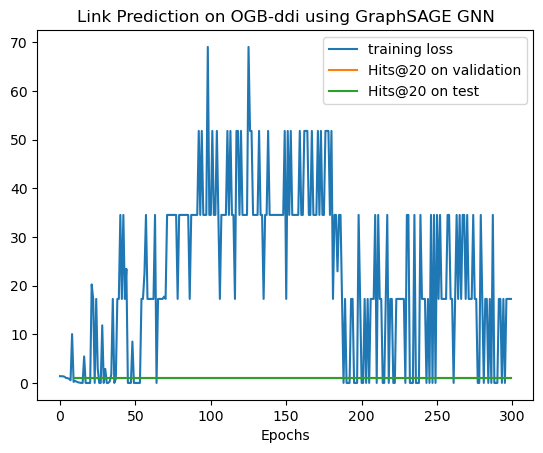

In [232]:


pos_train_edge = split_edge['train']['edge'].to(device)

emb = torch.nn.Embedding(graph.num_nodes, node_emb_dim).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device)
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

evaluator = Evaluator(name='ogbl-ddi')

get_gpu_memory()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)
edge_index = split_edge['train']['edge'].to(device)
# edge_index = val_data.edge_index.to(device)

print("Before training. Available GPU memory: ", get_gpu_memory())

train_loss = []
val_hits = []
test_hits = []
for e in tqdm(range(epochs)):
    loss = train(model, link_predictor, emb.weight, edge_index, pos_train_edge, batch_size, optimizer)
    if (e+1)%10 == 0:
        print(f"Epoch {e + 1}: loss: {round(loss, 5)}")
    train_loss.append(loss)

    if (e+1)%10 ==0:
        result = test(model, link_predictor, emb.weight, edge_index, split_edge, batch_size, evaluator)
        val_hits.append(result['Hits@20'][0])
        test_hits.append(result['Hits@20'][1])
        print(result)

plt.title('Link Prediction on OGB-ddi using GraphSAGE GNN')
plt.plot(train_loss,label="training loss")
plt.plot(np.arange(9,epochs,10),val_hits,label="Hits@20 on validation")
plt.plot(np.arange(9,epochs,10),test_hits,label="Hits@20 on test")
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [24]:
from torch_geometric.loader import NodeLoader

In [29]:
node_loader = NodeLoader(edge_list_user_article_interaction, nodes)

ValueError: too many values to unpack (expected 2)

/home/rgrebnev/anaconda3/envs/sna_link_prediction/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


tensor([[5, 0, 4,  ..., 2, 0, 0],
        [5, 0, 4,  ..., 2, 0, 0],
        [5, 0, 3,  ..., 1, 0, 1],
        ...,
        [6, 0, 2,  ..., 1, 1, 1],
        [7, 0, 2,  ..., 1, 1, 1],
        [5, 0, 3,  ..., 1, 1, 1]])